In [1]:
import os
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
%matplotlib inline  
%load_ext autoreload
%autoreload 2
import seaborn as sns
sns.set(style='darkgrid')
from copy import deepcopy
from torchvision import transforms
def print_np(x):
    print('(1) Type is %s' %(type(x)))
    print('(2) Shape is %s' %(x.shape,))
#     print('(3) Values are : \n%s' %(x))

In [2]:
from gpr import kernel_se, gpr

## data generation

In [3]:
# data (no noise)
x_data = np.linspace(-8,8,200).reshape((-1,1))
y_data = np.cos(np.pi/2*x_data)*np.exp(-(x_data/4)**2) 
# train (add noise)
# N_train = 50
x_train = np.vstack((np.linspace(-6,-2.5,90).reshape((-1,1)),np.linspace(-1.5,6,150).reshape((-1,1)) ))
y_train = np.cos(np.pi/2*x_train)*np.exp(-(x_train/4)**2) + 0.1*np.random.randn(*np.shape(x_train))
y_train += 0.5*np.random.randn(*np.shape(x_train)) * np.logical_and(x_train > 1,x_train < 3)

def plot_vline() :
    alpha = 0.3
    plt.vlines(-6, -2, 2, colors='k', linestyles='--',alpha=alpha)
    plt.vlines(-2.5, -2, 2, colors='k', linestyles='--',alpha=alpha)
    plt.vlines(-1.5, -2, 2, colors='k', linestyles='--',alpha=alpha)
    plt.vlines(1, -2, 2, colors='k', linestyles='--',alpha=alpha)
    plt.vlines(3, -2, 2, colors='k', linestyles='--',alpha=alpha)
    plt.vlines(6, -2, 2, colors='k', linestyles='--',alpha=alpha)
    
    plt.text(-7.8, -1.5, 'epistemic',fontsize=15,color='g')
    plt.text(-2.7, -1.5, 'epistemic',fontsize=15,color='g')
    plt.text(6.1, -1.5, 'epistemic',fontsize=15,color='g')
    plt.text(1.1, -1.5, 'Heteroscedastic',fontsize=15,color='g')
    plt.text(1.1, -1.7, 'aleatoric',fontsize=15,color='g')

Text(0.5, 1.0, 'Training Data for a Regression Task')

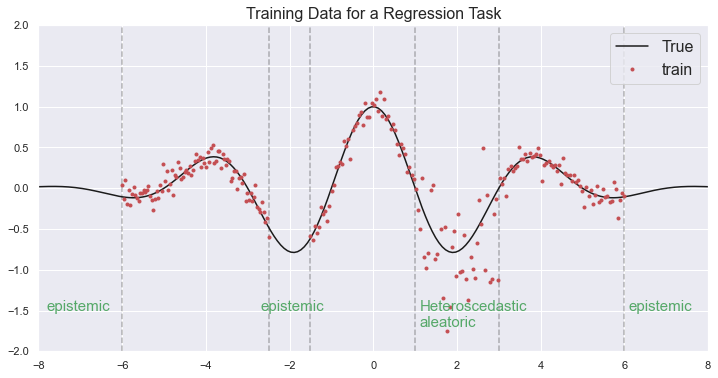

In [4]:
plt.figure(figsize=(12,6))
plt.axis([-8,8,-2.0,2.0])
plt.plot(x_data,y_data,label='True',color='k')
plt.plot(x_train,y_train,'r.',label='train')

plot_vline()
plt.grid(True)
plt.legend(fontsize=16)
plt.title('Training Data for a Regression Task',fontsize=16)

## Gaussian process regression

In [5]:
# Do inference
hyp={'gain':5,'len':1./1.,'s2w':1e-2*5}
GPR = gpr(_xTr=x_train,_yTr=y_train,_hyp=hyp)
y_pred, y_sigma_pred = GPR.inference(_xTe=x_data)
y_sigma_pred = y_sigma_pred.reshape((-1,1))

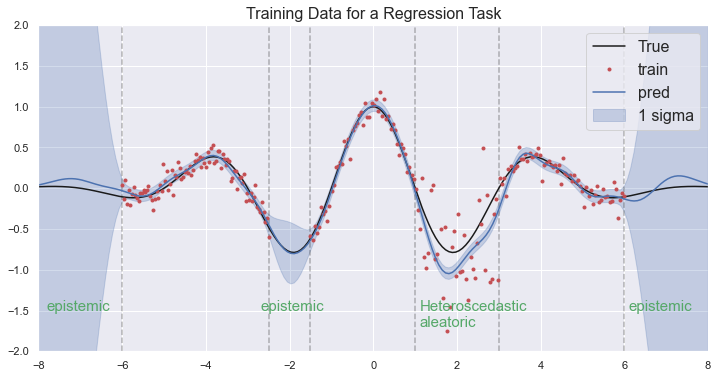

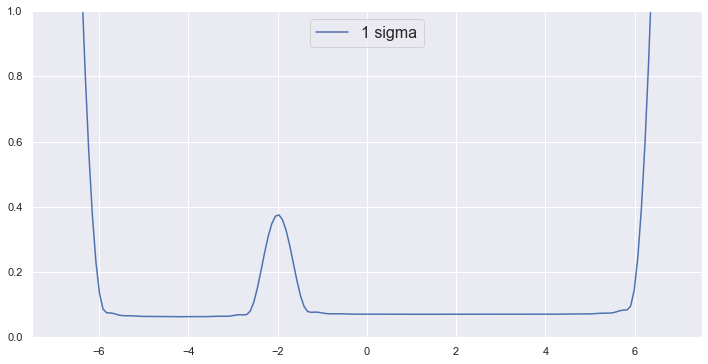

In [6]:
plt.figure(figsize=(12,6))
plt.axis([-8,8,-2.0,2.0])
plt.plot(x_data,y_data,label='True',color='k')
plt.plot(x_train,y_train,'r.',label='train')
plt.plot(x_data,y_pred,'b',label='pred')
plt.fill_between(x_data[:,0],y_pred[:,0]+y_sigma_pred[:,0],
                 y_pred[:,0]-y_sigma_pred[:,0],color='b',alpha=.25,label='1 sigma')

plot_vline()
plt.grid(True)
plt.legend(fontsize=16)
plt.title('Training Data for a Regression Task',fontsize=16)

plt.figure(figsize=(12,6))
plt.axis([-7.5,7.5,0.0,1.0])
plt.plot(x_data,y_sigma_pred,'b',label='1 sigma')
plt.legend(fontsize=16)

# Neural Net

In [7]:
import torch
from datasetter import SimpleDataset
from transformer import FloatToTensor
from trainer import RegressionTrainer
from models import LinearNN
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import nn

In [8]:
transform = transforms.Compose([
            FloatToTensor(),
        ])

In [9]:
# TODO : normalization

In [10]:
datasets = {}
datasets['train'] = SimpleDataset(x_train,y_train,np.shape(x_train)[0],transform)
datasets['valid'] = SimpleDataset(x_data,y_data,np.shape(x_data)[0],transform)

In [11]:
dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'],batch_size=128,shuffle=True)
dataloaders['valid'] = torch.utils.data.DataLoader(datasets['valid'],batch_size=len(x_train),shuffle=True)

In [12]:
num_hidden = 100
model = LinearNN(num_hidden,drop_prob=0.2)
print(model)
optimizer = optim.Adam(model.parameters(),lr=0.01)
criterion = nn.MSELoss()
# scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
scheduler = None

LinearNN(
  (fc1): Linear(in_features=1, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)


In [19]:
LinearNN_trainer = RegressionTrainer('hello')

In [20]:
LinearNN_trainer.train_model(model,criterion,optimizer,scheduler,500,dataloaders,False)

Epoch 0/499
----------
train loss is 0.0005
valid loss is 0.0002

Epoch 100/499
----------
train loss is 0.0005
valid loss is 0.0002

Epoch 200/499
----------
train loss is 0.0004
valid loss is 0.0002

Epoch 300/499
----------
train loss is 0.0005
valid loss is 0.0002

Epoch 400/499
----------
train loss is 0.0005
valid loss is 0.0002

Training complete in 0m 4s
Best loss: 0.000105


LinearNN(
  (fc1): Linear(in_features=1, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [21]:
model.eval()
y_pred = model(torch.from_numpy(x_data).float()).detach().numpy()

Text(0.5, 1.0, 'Training Data for a Regression Task')

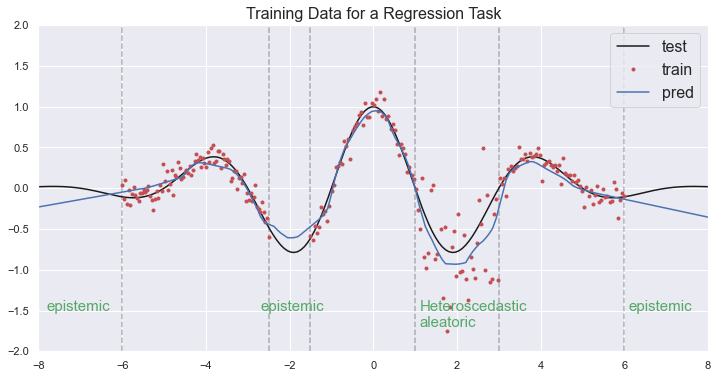

In [22]:
plt.figure(figsize=(12,6))
plt.axis([-8,8,-2.0,2.0])
plt.plot(x_data,y_data,label='test',color='k')
plt.plot(x_train,y_train,'r.',label='train')
plt.plot(x_data,y_pred,'b',label='pred')
plot_vline()
plt.grid(True)
plt.legend(fontsize=16)
plt.title('Training Data for a Regression Task',fontsize=16)

# Ensemble

In [30]:
num_hidden = 100
N_models = 10
list_model = []
list_optimizer = []
for i in range(N_models) :
    list_model.append(LinearNN(num_hidden,drop_prob=0.0))
    list_optimizer.append(optim.Adam(list_model[i].parameters(),lr=0.01))
criterion = nn.MSELoss()
# scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
scheduler = None

In [31]:
LinearNN_trainer = RegressionTrainer('hello')
for i in range(N_models) :
    LinearNN_trainer.train_model(list_model[i],criterion,list_optimizer[i],scheduler,500,dataloaders,False,verbose=False)

Training complete in 0m 4s
Best loss: 0.000112
Training complete in 0m 4s
Best loss: 0.000167
Training complete in 0m 4s
Best loss: 0.000151
Training complete in 0m 5s
Best loss: 0.000158
Training complete in 0m 4s
Best loss: 0.000138
Training complete in 0m 4s
Best loss: 0.000146
Training complete in 0m 4s
Best loss: 0.000092
Training complete in 0m 4s
Best loss: 0.000152
Training complete in 0m 4s
Best loss: 0.000143
Training complete in 0m 4s
Best loss: 0.000118


In [32]:
y_pred_list = np.zeros((len(x_data),N_models))
for i in range(N_models) :
    list_model[i].eval()
    y_pred_list[:,i] = np.squeeze(list_model[i](torch.from_numpy(x_data).float()).detach().numpy())
# print_np(y_pred_list)

In [33]:
y_pred_mean = np.mean(y_pred_list,axis=1)
y_pred_sigma = np.sqrt(np.var(y_pred_list,axis=1))
y_pred_mean = np.expand_dims(y_pred_mean,1)
y_pred_sigma = np.expand_dims(y_pred_sigma,1)
print_np(y_pred_sigma)

(1) Type is <class 'numpy.ndarray'>
(2) Shape is (200, 1)


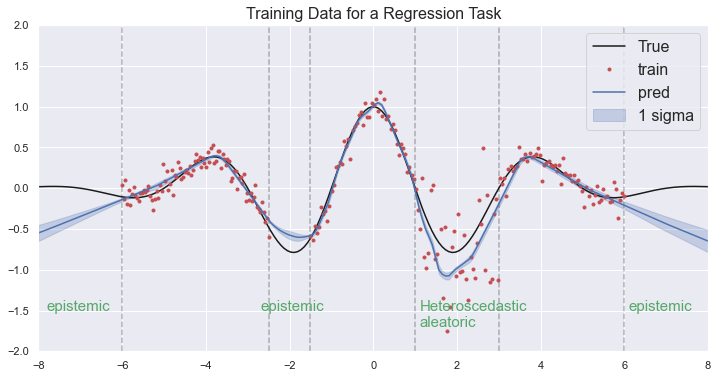

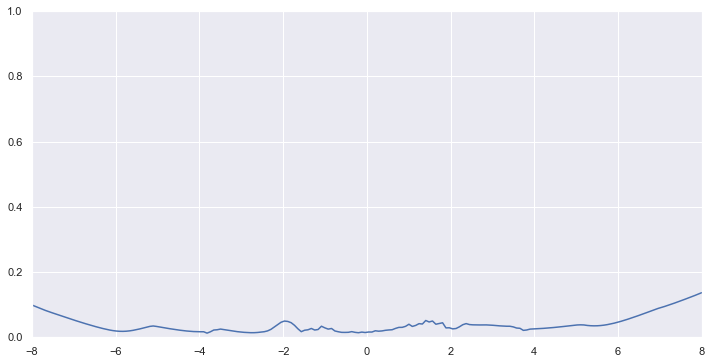

In [34]:
plt.figure(figsize=(12,6))
plt.axis([-8,8,-2.0,2.0])
plt.plot(x_data,y_data,label='True',color='k')
plt.plot(x_train,y_train,'r.',label='train')
plt.plot(x_data,y_pred_mean,'b',label='pred')
plt.fill_between(x_data[:,0],y_pred_mean[:,0]+y_pred_sigma[:,0],
                 y_pred_mean[:,0]-y_pred_sigma[:,0],color='b',alpha=.25,label='1 sigma')
plot_vline()
plt.grid(True)
plt.legend(fontsize=16)
plt.title('Training Data for a Regression Task',fontsize=16)

plt.figure(figsize=(12,6))
plt.axis([-8,8,0.0,1.0])
plt.plot(x_data,y_pred_sigma,'b',label='pred')

# Bayesian NN by dropout

In [35]:
def apply_dropout(m):
    if type(m) == nn.Dropout:
        m.train()
model.eval()
model.apply(apply_dropout)

LinearNN(
  (fc1): Linear(in_features=1, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)

In [36]:
N_samples = 20
y_pred_list = np.zeros((len(x_data),N_samples))
for i in range(N_samples) :
    y_pred_list[:,i] = np.squeeze(model(torch.from_numpy(x_data).float()).detach().numpy())
print_np(y_pred_list)

(1) Type is <class 'numpy.ndarray'>
(2) Shape is (200, 20)


In [37]:
y_pred_mean = np.mean(y_pred_list,axis=1)
y_pred_sigma = np.sqrt(np.var(y_pred_list,axis=1))
y_pred_mean = np.expand_dims(y_pred_mean,1)
y_pred_sigma = np.expand_dims(y_pred_sigma,1)
print_np(y_pred_sigma)

(1) Type is <class 'numpy.ndarray'>
(2) Shape is (200, 1)


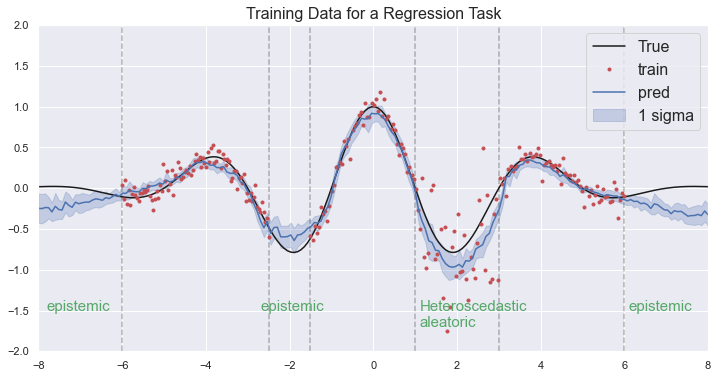

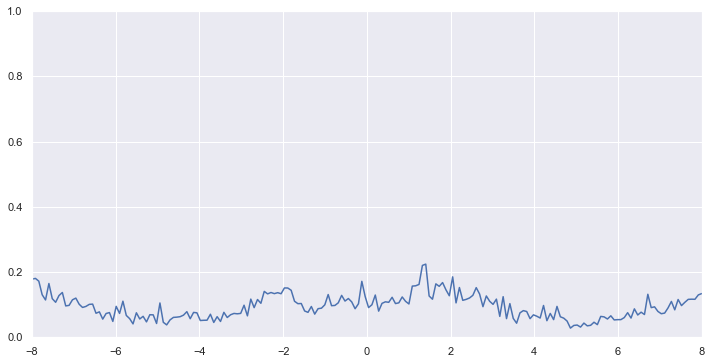

In [38]:
plt.figure(figsize=(12,6))
plt.axis([-8,8,-2.0,2.0])
plt.plot(x_data,y_data,label='True',color='k')
plt.plot(x_train,y_train,'r.',label='train')
plt.plot(x_data,y_pred_mean,'b',label='pred')
plt.fill_between(x_data[:,0],y_pred_mean[:,0]+y_pred_sigma[:,0],
                 y_pred_mean[:,0]-y_pred_sigma[:,0],color='b',alpha=.25,label='1 sigma')
plot_vline()
plt.grid(True)
plt.legend(fontsize=16)
plt.title('Training Data for a Regression Task',fontsize=16)

plt.figure(figsize=(12,6))
plt.axis([-8,8,0.0,1.0])
plt.plot(x_data,y_pred_sigma,'b',label='pred')

# Density network for aleatoric uncertainty

In [39]:
import torch
from datasetter import SimpleDataset
from transformer import FloatToTensor
from trainer import RegDensityTrainer
from models import LinearDensityNN
from utils import mdn_loss
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import nn

In [40]:
datasets = {}
datasets['train'] = SimpleDataset(x_train,y_train,np.shape(x_train)[0],transform)
datasets['valid'] = SimpleDataset(x_data,y_data,np.shape(x_data)[0],transform)

In [47]:
dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'],batch_size=16,shuffle=True)
dataloaders['valid'] = torch.utils.data.DataLoader(datasets['valid'],batch_size=len(x_train),shuffle=True)

In [48]:
num_hidden = 50
model = LinearDensityNN(num_hidden,drop_prob=0.0)
print(model)
optimizer = optim.Adam(model.parameters(),lr=0.001)
criterion = None
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

LinearDensityNN(
  (fc1): Linear(in_features=1, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3_1): Linear(in_features=50, out_features=1, bias=True)
  (fc3_2): Linear(in_features=50, out_features=1, bias=True)
  (dropout1): Dropout(p=0.0, inplace=False)
  (dropout2): Dropout(p=0.0, inplace=False)
)


In [53]:
DensityNN_trainer = RegDensityTrainer('hello')

In [54]:
DensityNN_trainer.train_model(model,criterion,optimizer,scheduler,500,dataloaders,False,True)

Epoch 0/499
----------
train loss is -1.5495
valid loss is -0.5167

Epoch 100/499
----------
train loss is -1.5726
valid loss is -1.0353

Epoch 200/499
----------
train loss is -1.5794
valid loss is -0.8158

Epoch 300/499
----------
train loss is -1.5342
valid loss is -1.0777

Epoch 400/499
----------
train loss is -1.5843
valid loss is -1.1192

Training complete in 0m 10s
Best loss: -1.284837


LinearDensityNN(
  (fc1): Linear(in_features=1, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3_1): Linear(in_features=50, out_features=1, bias=True)
  (fc3_2): Linear(in_features=50, out_features=1, bias=True)
  (dropout1): Dropout(p=0.0, inplace=False)
  (dropout2): Dropout(p=0.0, inplace=False)
)

In [55]:
model.eval()
y_pred, y_sigma = model(torch.from_numpy(x_data).float())#
y_pred = y_pred.detach().numpy()
y_sigma = y_sigma.detach().numpy()

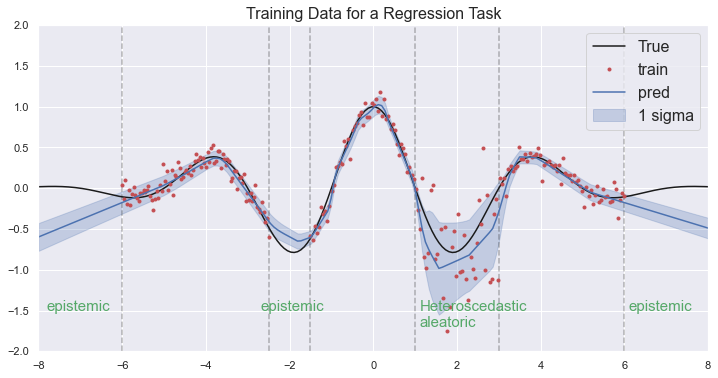

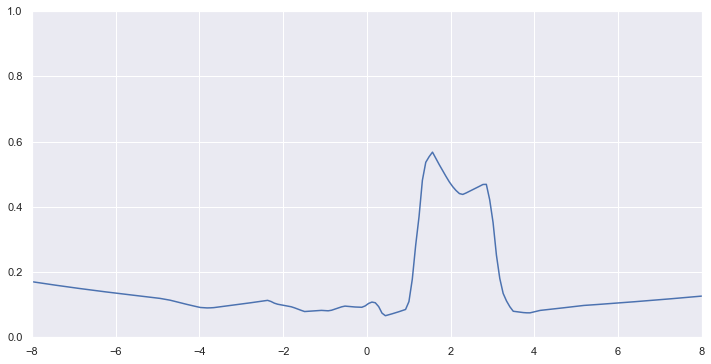

In [56]:
plt.figure(figsize=(12,6))
plt.axis([-8,8,-2.0,2.0])
plt.plot(x_data,y_data,label='True',color='k')
plt.plot(x_train,y_train,'r.',label='train')
plt.plot(x_data,y_pred,'b',label='pred')
plt.fill_between(x_data[:,0],y_pred[:,0]+y_sigma[:,0],
                 y_pred[:,0]-y_sigma[:,0],color='b',alpha=.25,label='1 sigma')
plot_vline()
plt.grid(True)
plt.legend(fontsize=16)
plt.title('Training Data for a Regression Task',fontsize=16)

plt.figure(figsize=(12,6))
plt.axis([-8,8,0.0,1.0])
plt.plot(x_data,y_sigma,'b',label='pred')